In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2

from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL

In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1.gin',
                   '../sparse_causal_model_learner_rl/configs/kc_dec.gin',
                   '../keychest/config/5x5_1f1c1k_obs.gin'])

['kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1', 'kc_dec', '5x5_1f1c1k_obs']

In [37]:
gin.bind_parameter('Config.collect_remotely', True)
gin.bind_parameter('Config.n_collectors', 5)
gin.bind_parameter('Config.future_buffer_size', 20)

In [5]:
learner = CausalModelLearnerRL(Config(ray_kwargs={'address': '127.0.0.1:6379'}))

2021-02-05 01:25:05,139	INFO worker.py:651 -- Connecting to existing Ray cluster at address: 10.90.38.7:6379


Selecting name 980f1434-6748-11eb-af1d-90e2baa1a248
Make environment KeyChest-v0 None {}


In [6]:
learner.create_trainables()

(pid=3897) Make environment KeyChest-v0 None {}


In [7]:
env = learner.env

In [8]:
losses = []
dplus = []

In [9]:
opt = torch.optim.Adam(lr=1e-3, params=learner.decoder.parameters())

In [11]:
for i in tqdm(range(1000)):
    if i % 10 == 0:
        ctx = learner.collect_and_get_context()
    
    opt.zero_grad()
    l_obj = siamese_feature_discriminator_l2(**ctx)
    loss = l_obj['loss']
    loss.backward()
    opt.step()
    losses.append(loss.item())
    dplus.append(l_obj['metrics']['distance_plus'])

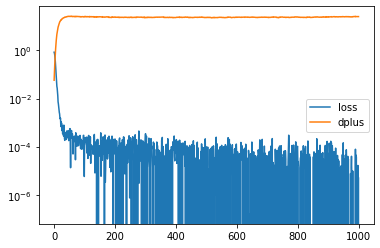

In [12]:
plt.plot(losses, label='loss')
plt.plot(dplus, label='dplus')
plt.yscale('log')
plt.legend()

In [13]:
np.mean(losses[-50:]), np.median(losses[-50:])

(1.2158731515228282e-05, 0.0)

In [14]:
features = learner.decoder(ctx['obs'])

In [15]:
f = features.detach().cpu().numpy()

In [16]:
f.shape

(5001, 30)

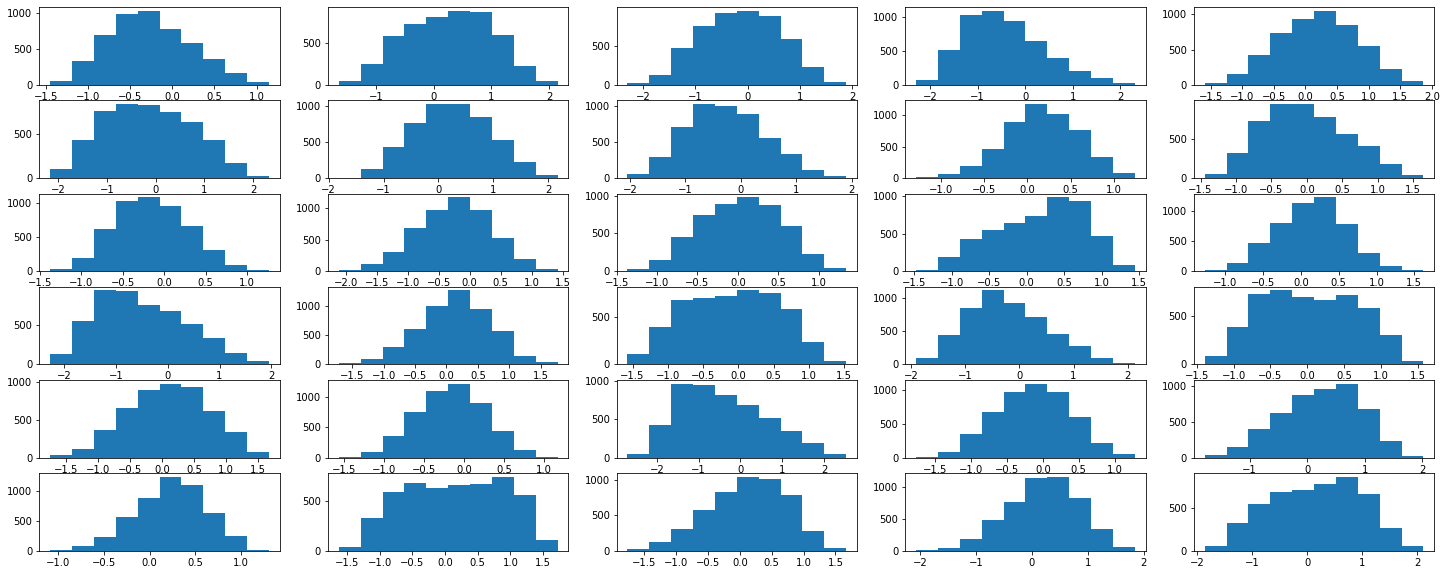

In [17]:
plt.figure(figsize=(25, 10))
for i_f in range(f.shape[1]):
    plt.subplot(6, 5, i_f + 1)
    plt.hist(f[:, i_f])

In [18]:
pd.DataFrame(f).std()

0     0.477647
1     0.724731
2     0.745158
3     0.818082
4     0.618016
5     0.890603
6     0.685409
7     0.698789
8     0.416432
9     0.582684
10    0.436252
11    0.577154
12    0.488384
13    0.580720
14    0.448021
15    0.839315
16    0.552214
17    0.643806
18    0.727381
19    0.627111
20    0.620992
21    0.424899
22    1.020827
23    0.510269
24    0.678956
25    0.381183
26    0.743369
27    0.597046
28    0.625884
29    0.811376
dtype: float32

<AxesSubplot:>

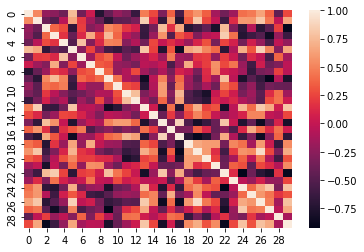

In [19]:
sns.heatmap(pd.DataFrame(f).corr())

In [20]:
env.engine.return_rgb = False

In [22]:
losses = []
metrics = []

In [23]:
gin.bind_parameter('model_gnn/FCCombinedModel.activation_cls', torch.nn.LeakyReLU)

In [24]:
learner.non_sparse_model.__init__(feature_shape=learner.feature_shape,
                                  action_shape=learner.action_shape,
                                  additional_feature_shape=learner.additional_feature_shape)
learner.non_sparse_model = learner.non_sparse_model.cuda()

In [25]:
learner.non_sparse_model.model.model.activation

[LeakyReLU(negative_slope=0.01),
 LeakyReLU(negative_slope=0.01),
 LeakyReLU(negative_slope=0.01),
 None]

In [26]:
learner.non_sparse_model

ManyNetworkCombinedModel(
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [27]:
learner.non_sparse_model.model.enable_switch

False

In [30]:
mins = None
maxes = None

In [31]:
def normalize(t, mins, maxes):
    return 2 * ((t - mins) / (1e-3 + maxes - mins) - 0.5)

In [33]:
class AdhocWorldModel(nn.Module):
    def __init__(self):
        super(AdhocWorldModel, self).__init__()
        self.fc1 = nn.Linear(in_features=34, out_features=60)
        self.fc2 = nn.Linear(in_features=60, out_features=60)
        self.fc3 = nn.Linear(in_features=60, out_features=60)
        self.fc4 = nn.Linear(in_features=60, out_features=32)
        self.activation = nn.Tanh()
        
    def forward(self, f_t, a_t, all):
        x = torch.cat([f_t, a_t], dim=1)
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        return x

In [34]:
#use_model = learner.non_sparse_model
use_model = AdhocWorldModel().cuda()

In [35]:
opt = torch.optim.Adam(lr=1e-3, params=use_model.parameters())

In [36]:
for i in tqdm(range(1000)):
    if i % 10 == 0:
        ctx = learner.collect_and_get_context()
        
        if mins is None or maxes is None:
            print("Computing minmax")
            f_all = learner.decoder(ctx['obs'])
            mins = f_all.min(dim=0, keepdim=True).values.detach()
            maxes = f_all.max(dim=0, keepdim=True).values.detach()
        
        f_t1 = learner.decoder(ctx['obs_y']).detach()
        f_t = learner.decoder(ctx['obs_x']).detach()
        
        f_t1 = normalize(f_t1, mins, maxes)
        f_t = normalize(f_t, mins, maxes)
        
        add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
        f_t1 = torch.cat([f_t1, add_features_y], dim=1)
    f_t1_pred = use_model(
        f_t,
        ctx['action_x'],
        all=True)
    
    loss = nn.MSELoss()(f_t1, f_t1_pred)

    
    opt.zero_grad()
#     l_obj = context_rewriter(function=fit_loss, rewrite={'model': 'non_sparse_model'}, **ctx)
#     loss = l_obj['loss']
    loss.backward()
    opt.step()
    losses.append(loss.item())
#     metrics.append(l_obj['metrics'])

Computing minmax



KeyboardInterrupt: 

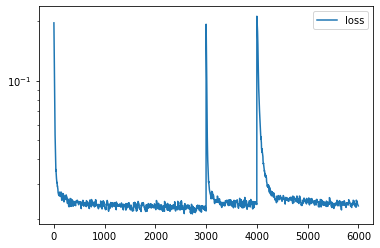

In [135]:
plt.plot(losses, label='loss')
#plt.plot(dplus, label='dplus')
plt.yscale('log')
plt.legend()

In [98]:
metrics_dct = lstdct2dctlst(metrics)
for key, vals in metrics_dct.items():
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key)
plt.legend()
plt.show()

IndexError: list index out of range

In [32]:
metrics_dct.keys()

dict_keys(['mean_feature', 'std_feature', 'min_feature', 'max_feature', 'std_feature_avg', 'inv_std_feature_avg'])